In [15]:
%load_ext autotime
RANDOM_STATE = 42

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.2 ms


In [16]:
import pandas as pd
from os.path import abspath
from sklearn.model_selection import train_test_split

time: 1.05 ms


In [17]:
dataset = pd.read_csv(abspath('./data.csv'))
dataset['text'] = dataset['text'].str.lower()
dataset['target'] = dataset['outcome']
dataset.head(10)

,title,text,subject,date,outcome,target
0,"As U.S. budget fight looms, Republicans flip t...",washington (reuters) - the head of a conservat...,politicsNews,"December 31, 2017",1,1
1,U.S. military to accept transgender recruits o...,washington (reuters) - transgender people will...,politicsNews,"December 29, 2017",1,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington (reuters) - the special counsel inv...,politicsNews,"December 31, 2017",1,1
3,FBI Russia probe helped by Australian diplomat...,washington (reuters) - trump campaign adviser ...,politicsNews,"December 30, 2017",1,1
4,Trump wants Postal Service to charge 'much mor...,seattle/washington (reuters) - president donal...,politicsNews,"December 29, 2017",1,1
5,"White House, Congress prepare for talks on spe...","west palm beach, fla./washington (reuters) - t...",politicsNews,"December 29, 2017",1,1
6,"Trump says Russia probe will be fair, but time...","west palm beach, fla (reuters) - president don...",politicsNews,"December 29, 2017",1,1
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,the following statements were posted to the ve...,politicsNews,"December 29, 2017",1,1
8,Trump on Twitter (Dec 28) - Global Warming,the following statements were posted to the ve...,politicsNews,"December 29, 2017",1,1
9,Alabama official to certify Senator-elect Jone...,washington (reuters) - alabama secretary of st...,politicsNews,"December 28, 2017",1,1


time: 934 ms


In [18]:
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['target'], test_size=0.2, random_state=RANDOM_STATE)

time: 7.8 ms


In [19]:
X_train.head(5)

18628    vienna (reuters) - the number 2 figure in aust...
17520    nairobi (reuters) - in a dramatic picture, ken...
28354    ben stein is on a trump-bashing spree again, a...
3803     washington (reuters) - former director of nati...
3566     brussels (reuters) - a smiling donald trump of...
Name: text, dtype: object

time: 4.9 ms


In [20]:
y_train.head(5)

18628    1
17520    1
28354    0
3803     1
3566     1
Name: target, dtype: int64

time: 5.1 ms


In [35]:
y_train.shape,y_test.shape

((35912,), (8979,))

time: 4.3 ms


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

time: 21.4 s


In [22]:
# Model Config
model_metrices =['accuracy']
batch_size = 64
embedding_dimensions = 16
loss_function = BinaryCrossentropy()
max_sequence_length = 10
num_distinct_words = 5000
optimizer = 'adam'
validation_split = 0.2

time: 920 µs


In [23]:
tokenizer = Tokenizer(num_words=num_distinct_words)
tokenizer.fit_on_texts(X_train)

time: 10.3 s


In [24]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

time: 10.4 s


In [25]:
padded_X_train = pad_sequences(X_train, maxlen=max_sequence_length, value=0) # 0.0 because it corresponds with <PAD>
padded_X_test = pad_sequences(X_test, maxlen=max_sequence_length, value=0)

time: 190 ms


In [26]:
lstm_input = Input(shape=(max_sequence_length))
lstm_layer = Embedding(num_distinct_words, embedding_dimensions, input_length = max_sequence_length)(lstm_input)

lstm_layer = LSTM(64)(lstm_layer)

lstm_layer = Dense(32, activation='relu')(lstm_layer)

lstm_output = Dense(1, activation='sigmoid')(lstm_layer)

time: 8.06 s


In [27]:
lstm_model = Model(inputs=lstm_input, outputs=lstm_output)
lstm_model.compile(optimizer=optimizer, loss=loss_function, metrics=model_metrices)

time: 25.8 ms


In [28]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 16)            80000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 102,849
Trainable params: 102,849
Non-trainable params: 0
_________________________________________________________________
time: 2.08 ms


In [29]:
earlyStopCb = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=3)
lstm_history = lstm_model.fit(padded_X_train, y_train, batch_size=batch_size, epochs=100, validation_split=validation_split, callbacks=[earlyStopCb])

Epoch 1/100
449/449 [==============================] - 32s 6ms/step - loss: 0.3740 - accuracy: 0.8134 - val_loss: 0.1498 - val_accuracy: 0.9407
Epoch 2/100
449/449 [==============================] - 2s 5ms/step - loss: 0.1131 - accuracy: 0.9567 - val_loss: 0.1470 - val_accuracy: 0.9458
Epoch 3/100
449/449 [==============================] - 2s 5ms/step - loss: 0.0822 - accuracy: 0.9696 - val_loss: 0.1542 - val_accuracy: 0.9433
Epoch 4/100
449/449 [==============================] - 2s 5ms/step - loss: 0.0684 - accuracy: 0.9754 - val_loss: 0.1722 - val_accuracy: 0.9424
Epoch 5/100
449/449 [==============================] - 2s 5ms/step - loss: 0.0525 - accuracy: 0.9816 - val_loss: 0.1864 - val_accuracy: 0.9428
time: 40.7 s


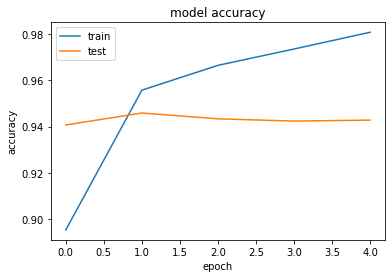

time: 507 ms


In [30]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
lstm_results = (lstm_model.predict(padded_X_test)).round()

time: 630 ms


In [32]:
lstm_report = classification_report(y_test, lstm_results)

time: 19.9 ms


In [33]:
print(lstm_report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4676
           1       0.93      0.94      0.94      4303

    accuracy                           0.94      8979
   macro avg       0.94      0.94      0.94      8979
weighted avg       0.94      0.94      0.94      8979

time: 610 µs
